In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from nltk import FreqDist
from wordcloud import WordCloud
from pathlib import Path

In [62]:
carpeta = Path(r"C:\Users\sayur\Downloads\Proyecto_Bedu\data\utf8")
dataframes = {}  # diccionario vacío

for archivo in carpeta.glob('*.csv'):
    nombre_tabla = archivo.stem
    dataframes[nombre_tabla] = pd.read_csv(archivo, dtype=str, low_memory=False, na_filter=True)

In [63]:
for k in dataframes.keys():
    print(k)

2020
2021
2022
2023
2024
2025


In [91]:
df_2025=dataframes["2025"]
df_2024=dataframes["2024"]
df_2023=dataframes["2023"]
df_2022=dataframes["2022"]
df_2021=dataframes["2021"]
df_2020=dataframes["2020"]

In [92]:
for nombre, df in dataframes.items():
    # columnas a minúsculas
    df.columns = df.columns.str.lower()

    # contenido a minúsculas en columnas de texto
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].map(lambda x: x.lower() if isinstance(x, str) else x)

        # reemplazar valores de texto que representan nulos por NaN real
        df[col] = df[col].replace(
            ["nan", "null", "none", "na", "", " "], 
            np.nan
        )

    dataframes[nombre] = df

In [93]:
for nombre, df in dataframes.items():
    # convertir columnas numéricas de texto a float
    for col in df.select_dtypes(include="object").columns:
        try:
            df[col] = df[col].astype(float)
        except:
            pass  # ignora si no se puede convertir

    dataframes[nombre] = df

In [94]:
#Visualizacion de datos
# Primeras filas
df_2025.head(2)

,estado,ene,feb,mar,abr,may,jun,jul,ago,sep,oct,nov,dic,anual
0,aguascalientes,9.5,0.0,0.0,0.1,32.7,157.8,143.8,139.3,483.2,NaN,NaN,NaN,NaN
1,bajacalifornia,3.8,4.7,28.9,3.2,2.4,5.4,0.3,7.8,56.4,NaN,NaN,NaN,NaN


In [95]:
# Estadísticas descriptivas
df_2025.describe()

,ene,feb,mar,abr,may,jun,jul,ago,sep,oct,nov,dic,anual
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,0.0,0.0,0.0,0.0
mean,23.790909,18.118182,8.078788,7.387879,63.181818,198.727273,127.681818,153.093939,600.033333,NaN,NaN,NaN,NaN
std,25.669332,27.465290,12.285351,11.827768,54.445675,120.814184,61.176208,94.726775,307.556968,NaN,NaN,NaN,NaN
min,1.200000,0.000000,0.000000,0.000000,0.600000,3.500000,0.300000,7.800000,56.400000,NaN,NaN,NaN,NaN
25%,9.500000,0.100000,0.100000,0.300000,28.600000,89.800000,99.200000,91.800000,446.000000,NaN,NaN,NaN,NaN
50%,14.000000,5.600000,2.700000,2.600000,59.200000,189.700000,125.300000,139.300000,570.300000,NaN,NaN,NaN,NaN
75%,30.200000,19.300000,8.400000,8.600000,80.400000,262.300000,163.100000,189.700000,799.900000,NaN,NaN,NaN,NaN
max,113.400000,122.400000,55.500000,55.400000,260.700000,466.000000,264.600000,400.400000,1415.400000,NaN,NaN,NaN,NaN


In [115]:
## Análisis descriptivo por año y estado

In [98]:
# --- 1. Promedio anual por estado ---
promedio_anual = df[["estado","anual"]].sort_values("anual", ascending=False)
print("Promedio anual por estado (2025):\n", promedio_anual)

# --- 2. Promedio mensual nacional ---
promedio_mensual = df.drop(columns=["estado","anual"]).mean()
print("\nPromedio mensual nacional (2025):\n", promedio_mensual)

# --- 3. Desviación estándar (variabilidad entre estados) ---
variabilidad = df.drop(columns=["estado"]).std()
print("\nDesviación estándar (2025):\n", variabilidad)

# --- 4. Tendencia anual ---
anuales = {}
for year, dfx in dataframes.items():
    anuales[year] = dfx["anual"].astype(float).mean()

df_tendencia = pd.DataFrame.from_dict(anuales, orient="index", columns=["promedio_anual"])
print("\nPromedio anual nacional por año:\n", df_tendencia)


Promedio anual por estado (2025):
                estado  anual
0      aguascalientes    NaN
1      bajacalifornia    NaN
2   bajacaliforniasur    NaN
3            campeche    NaN
4            coahuila    NaN
5              colima    NaN
6             chiapas    NaN
7           chihuahua    NaN
8      ciudaddeméxico    NaN
9             durango    NaN
10         guanajuato    NaN
11           guerrero    NaN
12            hidalgo    NaN
13            jalisco    NaN
14     estadodeméxico    NaN
15          michoacán    NaN
16            morelos    NaN
17            nayarit    NaN
18          nuevoleón    NaN
19             oaxaca    NaN
20             puebla    NaN
21          querétaro    NaN
22        quintanaroo    NaN
23      sanluispotosí    NaN
24            sinaloa    NaN
25             sonora    NaN
26            tabasco    NaN
27         tamaulipas    NaN
28           tlaxcala    NaN
29           veracruz    NaN
30            yucatán    NaN
31          zacatecas    NaN
32      

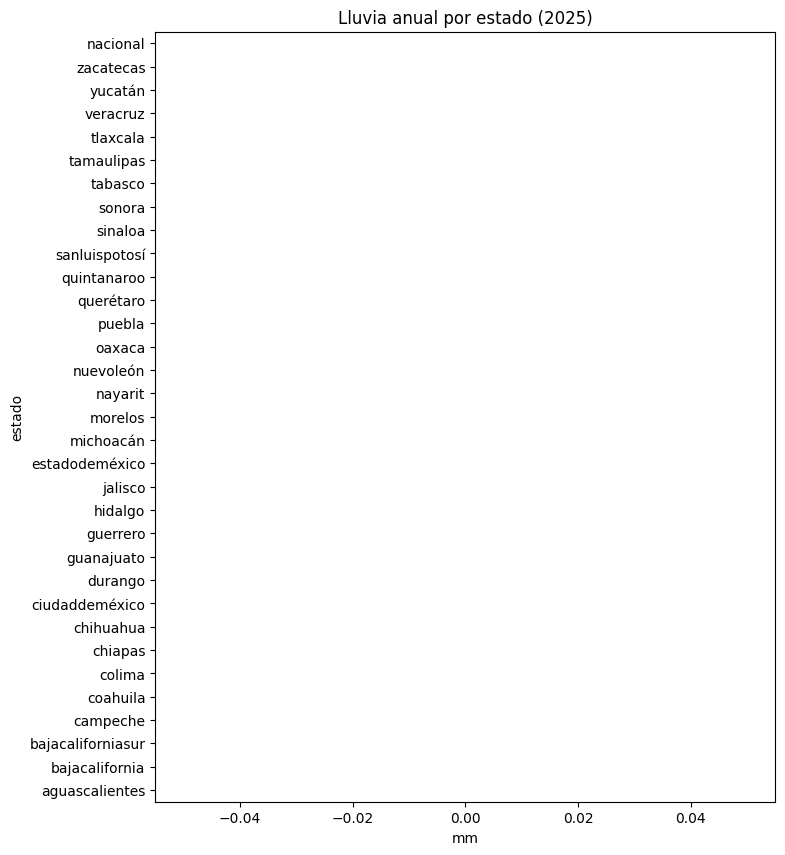

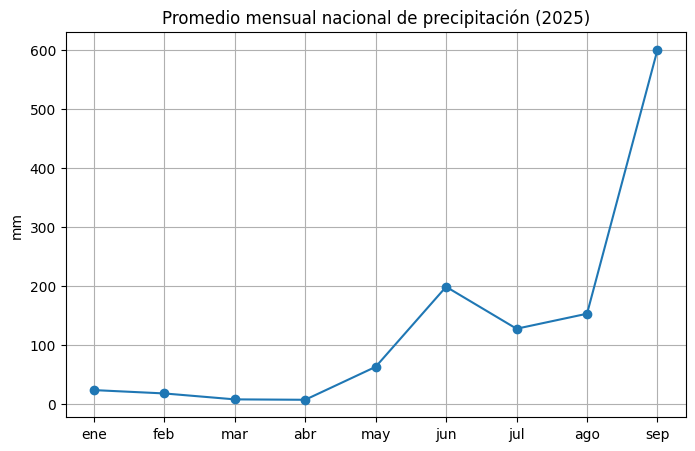

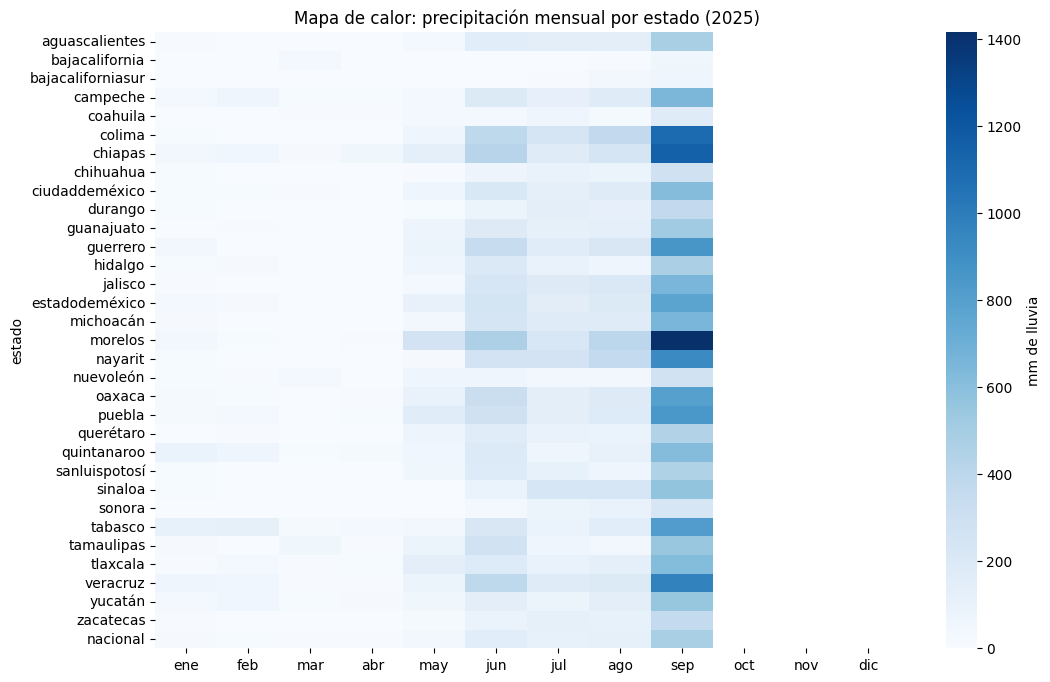

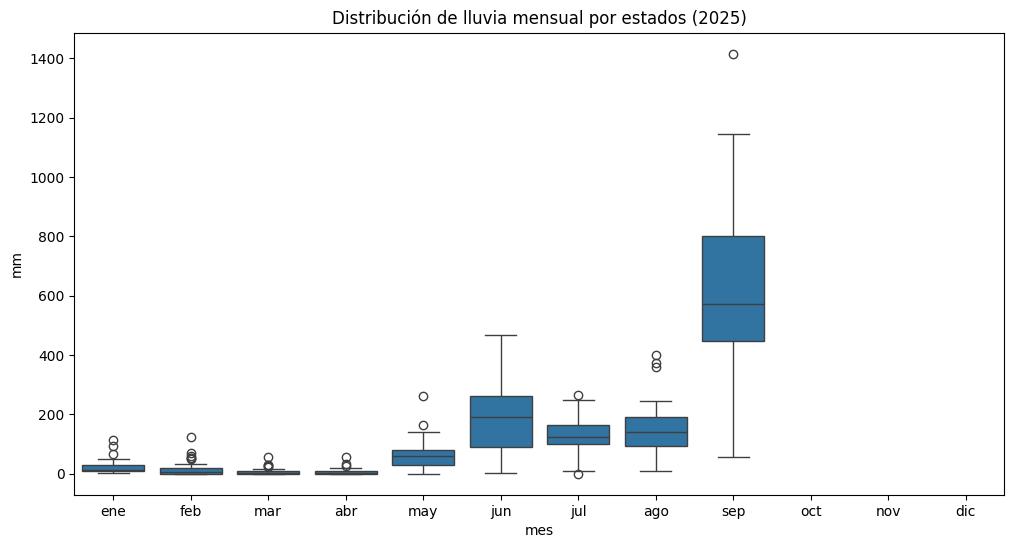

In [130]:
# --- 1. Barra horizontal: lluvia anual por estado ---
df.set_index("estado")["anual"].astype(float).sort_values().plot(kind="barh", figsize=(8,10))
plt.title("Lluvia anual por estado (2025)")
plt.xlabel("mm")
plt.show()

# --- 2. Promedio mensual nacional ---
promedio_mensual.plot(kind="line", marker="o", figsize=(8,5))
plt.title("Promedio mensual nacional de precipitación (2025)")
plt.ylabel("mm")
plt.grid(True)
plt.show()

# --- 3. Mapa de calor por estado y mes ---
plt.figure(figsize=(12,8))
df_meses = df.set_index("estado").drop(columns="anual").astype(float)
sns.heatmap(df_meses, cmap="Blues", cbar_kws={'label': 'mm de lluvia'})
plt.title("Mapa de calor: precipitación mensual por estado (2025)")
plt.show()

# --- 4. Boxplot por mes ---
df_melt = df.melt(id_vars="estado", value_vars=["ene","feb","mar","abr","may","jun","jul","ago","sep","oct","nov","dic"],
                  var_name="mes", value_name="lluvia")
df_melt["lluvia"] = df_melt["lluvia"].astype(float)

plt.figure(figsize=(12,6))
sns.boxplot(data=df_melt, x="mes", y="lluvia")
plt.title("Distribución de lluvia mensual por estados (2025)")
plt.ylabel("mm")
plt.show()